# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap

/home/surchs/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "/home/surchs/.config/matplotlib/matplotlibrc", line #405
  (fname, cnt))


In [2]:
%matplotlib inline

In [3]:
# Paths
scale = 12
subtypes = 3
network_number = 1
net_id = network_number - 1
mtp = 'stability_maps'
tpl = '*_fmri_{:07d}_session_1_run1_stability_maps.nii.gz'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale012.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)
# Grab the corresponding file paths - should be sure that they exist
path_list = [glob.glob(os.path.join(data_path, mtp, tpl.format(r['SUB_ID'])))[0] for i, r in pheno.iterrows()]

## Build the subtypes and compute the weights

In [108]:
def save_nifti(vec, mask_img, file_name):
    mask_data = mask_img.get_data()
    mask = mask_data != 0
    # Remap the map into volume space
    template = np.zeros_like(mask, dtype=np.float64)
    template[mask] = vec
    # Make a nifti image out of the volume
    nifti_vol = nib.Nifti1Image(template, affine=mask_img.get_affine(), header=mask_img.get_header())
    nib.save(nifti_vol, file_name)
    return 'saved @ {}'.format(file_name)

In [ ]:
# Store the subtypes in a 4D volume
def save_4D_nifti(mat, mask_img, file_name):
    # Get number of vectors to store
    n_vec = mat.shape[0]
    # Get the mask
    mask_data = mask_img.get_data()
    mask = mask_data != 0
    # Prepare the output
    out_vol = np.zeros((mask.shape + (n_vec,)))
    # Iterate through the vectors
    for vec_id in range(n_vec):    
        # Get the vec
        vec = mat[vec_id, :]
        # Remap the map into volume space
        template = np.zeros_like(mask, dtype=np.float64)
        template[mask] = vec
        out_vol[..., vec_id] = template
        
    # Make a nifti image out of the volume
    nifti_vol = nib.Nifti1Image(out_vol, affine=mask_img.get_affine(), header=mask_img.get_header())
    nib.save(nifti_vol, file_name)
    return 'stored the volume @ {}'.format(file_name)

In [6]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [138]:
def show_all_subtypes(sbt_store, net_id, mask, m_img, fsz=(10,8), rng=None, colm=hotcold, thr='auto'):
    sub_stack = sbt_store[net_id, ...]
    n_sbt = sub_stack.shape[0]
    # Prepare the figure
    fig = plt.figure(figsize=fsz)
    gs = gridspec.GridSpec(n_sbt, 1, hspace=0.3)
    for s_id in range(n_sbt):
        sbt_map = sub_stack[s_id,:]
        # Remap the map into volume space
        template = np.zeros_like(mask, dtype=np.float64)
        template[mask] = sbt_map
        # Make a nifti image out of the volume
        nifti_vol = nib.Nifti1Image(template, affine=m_img.get_affine(), header=m_img.get_header())
        # Visualize the thing with nilearn
        ax = fig.add_subplot(gs[s_id,0])
        if not rng:
            rng=(None, None)
        nlp.plot_glass_brain(nifti_vol, title='subtype {}'.format(s_id+1),
                             axes=ax, cmap=colm, colorbar=True, 
                             vmin=rng[0], vmax=rng[1], threshold=thr)
    return fig

In [141]:
def show_subtype(sbt_map, mask, m_img, fsz=(10,8), tit=None, rng=None, colm=hotcold, thr='auto'):
    # Remap the map into volume space
    template = np.zeros_like(mask, dtype=np.float64)
    template[mask] = sbt_map
    fig = plt.figure(figsize=fsz)
    ax = fig.add_subplot(111)
    # Make a nifti image out of the volume
    nifti_vol = nib.Nifti1Image(template, affine=m_img.get_affine(), header=m_img.get_header())
    # Visualize the thing with nilearn
    if not rng:
        rng=(None, None)
    nlp.plot_glass_brain(nifti_vol, title=tit, cmap=colm, colorbar=True, 
                         vmin=rng[0], vmax=rng[1], threshold=thr, axes=ax)
    return fig

In [111]:
# Show the weights and run a t-test between them as well
def cat_weights(wl):
    n_1 = len(wl[0])
    n_2 = len(wl[1])
    ind_1 = np.ones(n_1) + (np.random.random(n_1)*2-1)*0.05
    ind_2 = np.ones(n_2) + (np.random.random(n_2)*2-1)*0.05 + 1
    plt.plot(ind_1, wl[0], 'k.')
    plt.plot(ind_2, wl[1], 'k.')
    plt.boxplot(wl)
    [t,p] = st.ttest_ind(wl[0], wl[1])
    plt.title('T {:.2f} ({:.4f})'.format(t,p))
    plt.xticks([1,2], ['ASD', 'TDC'], rotation=60)
    plt.ylabel('Weights')

##Build the GLM

In [9]:
# Generate the model matrix
factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

In [136]:
# Run over all subtypes and networks
scale = 12
subtypes = 5
n_vox = np.sum(mask)
n_files = len(path_list)
# Let's run the model again for all networks and subtypes
gdavg = np.zeros(mask.shape + (scale,))
pval_store = np.zeros((scale, subtypes))
weight_store = np.zeros((scale, subtypes, n_files))
sbt_store = np.zeros((scale, subtypes, n_vox))
sbt_store_2 = np.zeros((scale, subtypes, n_vox))
part_store = np.zeros((scale, n_files))
res_store = list()
timer = bb.tools.Counter(scale)
for net_id in range(scale):
    res_list = list()
    timer.tic()
    # Get the scores maps into a voxel by subject array
    # Init store
    net_stack = np.zeros((n_vox, n_files))
    # Iterate files
    for index, s_path in enumerate(path_list):
        # Getting data
        f_net = nib.load(s_path).get_data()[mask][..., net_id]
        net_stack[..., index] = f_net
    
    grand_average = np.reshape(np.mean(net_stack, 1), (net_stack.shape[0], 1))
    # Save a copy of the non-demeanded subtypes
    net_stack_2 = np.copy(net_stack)
    # Demean the net stack
    net_stack = net_stack - grand_average
    # Save the grand average
    tmpl = np.zeros_like(mask, dtype=np.float16)
    tmpl[mask] = grand_average[:, 0]
    gdavg[..., net_id] = tmpl
    
    # Build correlation matrix on the network stack
    corr_mat = np.corrcoef(net_stack, rowvar=0)
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat, method='ward')
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub
    
    # Init store - Build subtypes
    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(net_stack[:, part_sub==s_id+1],1)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt
        
    # Make the non-demeaned subtypes
    for s_id in range(subtypes):
        sbt = np.mean(net_stack_2[:, part_store[net_id, :]==s_id+1],1)
        sbt_store_2[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, net_stack[:,x])[0,1] for x in range(n_files)])
        
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(weight_store[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues['DX_GROUP']
        res_list.append(results)
    timer.toc()
    res_store.append(res_list)
    timer.progress()

 100.0 % done 0.00 seconds to go. One step takes 16.29914 and we ran for 211.89 s so far

In [260]:
def visu_net(corr_sub, link_sub, val_range=[0,1], colm=plt.cm.coolwarm):
    """
    Show the correlation map and the hierarchical clustering
    to get an idea of the data structure
    """
    f = plt.figure(figsize=(8,10))
    ax = f.add_subplot(111)
    subdend = bb.visu.add_subplot_axes(ax, [0, 0.71, 0.9, 0.29])
    submat = bb.visu.add_subplot_axes(ax, [0, 0, 0.9, 0.7])
    subcol = bb.visu.add_subplot_axes(ax, [0.91, 0, 0.09, 1])
    Z1 = scl.hierarchy.dendrogram(link_sub, ax=subdend, color_threshold=6)
    idx = Z1['leaves']
    tmp = corr_sub[idx, :]
    show_corr = tmp[:, idx]
    pc = submat.matshow(show_corr, aspect='auto',vmin=val_range[0], vmax=val_range[1], cmap=colm)
    plt.colorbar(pc, cax=subcol)
    subdend.set_xticklabels([])
    submat.set_xticklabels([])
    submat.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return f

In [265]:
corr_mat.shape

(189, 189)

In [264]:
link_mat.shape

(188, 4)

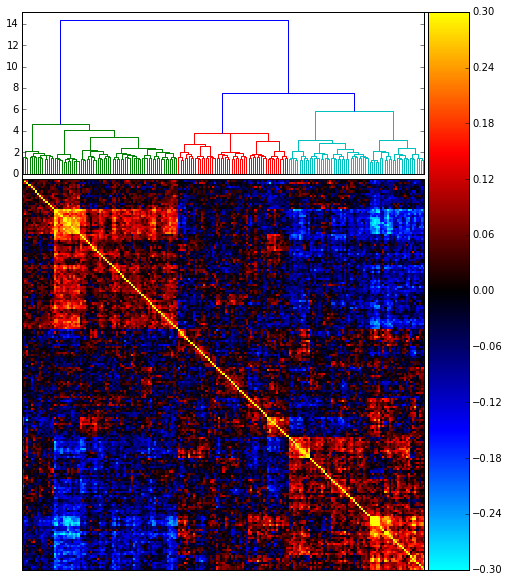

In [263]:
part_order = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']
tmp = corr_mat[part_order, :]
cm = tmp[:, part_order]
fig = visu_net(corr_mat, link_mat, val_range=[-0.3,0.3], colm=hotcold)
fig.savefig(os.path.join(out_path, 'example_mat.png'), dpi=150)

In [137]:
# Save subtype 5 to disk
save_path = os.path.join(out_path, 'grand_average.nii.gz')
nifti_vol = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())
nib.save(nifti_vol, save_path)

<matplotlib.colorbar.Colorbar instance at 0xbe1ee60>

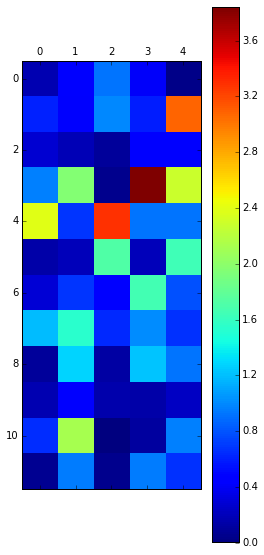

In [14]:
plt.matshow(-np.log10(pval_store))
plt.colorbar()

In [15]:
# FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)

<matplotlib.colorbar.Colorbar instance at 0xa457128>

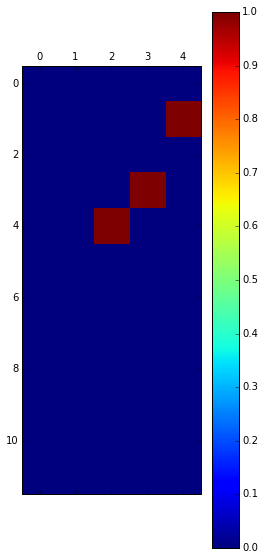

In [16]:
plt.matshow(pcorr_store)
plt.colorbar()

Alright, let's go with diagnosis for now. Eventually it makes sense to look at the underlying scores and try to build something out of that. However, that will be a lot of tests.

# Association with diagnosis passing FDR

In [20]:
# Look at the results passing FDR
np.argwhere(pcorr_store)

array([[1, 4],
       [3, 3],
       [4, 2]])

Note that the numpy array is zero-indexed.

At scale 12 with 5 subtypes I find 3 results passing FDR. Those are:

1. Network 2 and subtype 5
2. Network 4 and subtype 4
3. Network 5 and subtype 3

Let's take a closer look at these networks

In [21]:
# I'll load the priors
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [22]:
# Find the subjects that are ASD (1) and controls (2)
sub_asd = pheno['DX_GROUP'].values == 1
sub_tdc = pheno['DX_GROUP'].values == 2

## Network 2

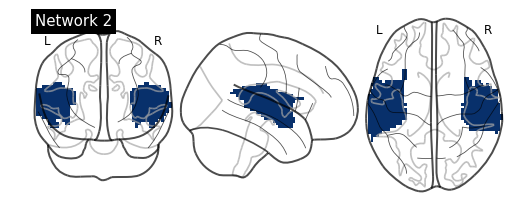

In [149]:
# Show network 2
n2 = np.zeros_like(prior)
n2[prior==2] = 1

n2_img = nib.Nifti1Image(n2, affine=p_img.get_affine(), header=p_img.get_header())
# Visualize the thing with nilearn
nlp.plot_glass_brain(n2_img, title='Network 2', cmap=plt.cm.Blues_r)

Looks like a limbic network to me. __Definitely need a label for each of these networks!__ Let's see the subtypes

In [288]:
sbt_store[1,4,:].shape

(45309,)

In [293]:
dtest = np.random.random((sbt_store[1,4,:].shape))*-10

In [294]:
dtest.shape

(45309,)

In [297]:
a = show_subtype(dtest, mask, m_img, fsz=(10,4), tit='sbt5 net2')

TypeError: show_subtype() got an unexpected keyword argument 'vmin'

In [ ]:
a = show_subtype(sbt_store[1,4,:], mask, m_img, fsz=(10,4), tit='sbt5 net2')

Subtype 5 looks more posterior than the other subtypes.

In [151]:
# Save subtype 5 to disk
save_path = os.path.join(out_path, 'network_2_subtype_5.nii.gz')
save_nifti(sbt_store[1,4,:], m_img, save_path)

'saved @ /data1/subtypes/sc12/network_2_subtype_5.nii.gz'

In [152]:
# Also save the other subtypes to disk
save_path = os.path.join(out_path, 'network_2_subtypes.nii.gz')
save_4D_nifti(sbt_store[1,...], m_img, save_path)

save_path = os.path.join(out_path, 'network_2_subtypes_not_demean.nii.gz')
save_4D_nifti(sbt_store_2[1,...], m_img, save_path)

'stored the volume @ /data1/subtypes/sc12/network_2_subtypes_not_demean.nii.gz'

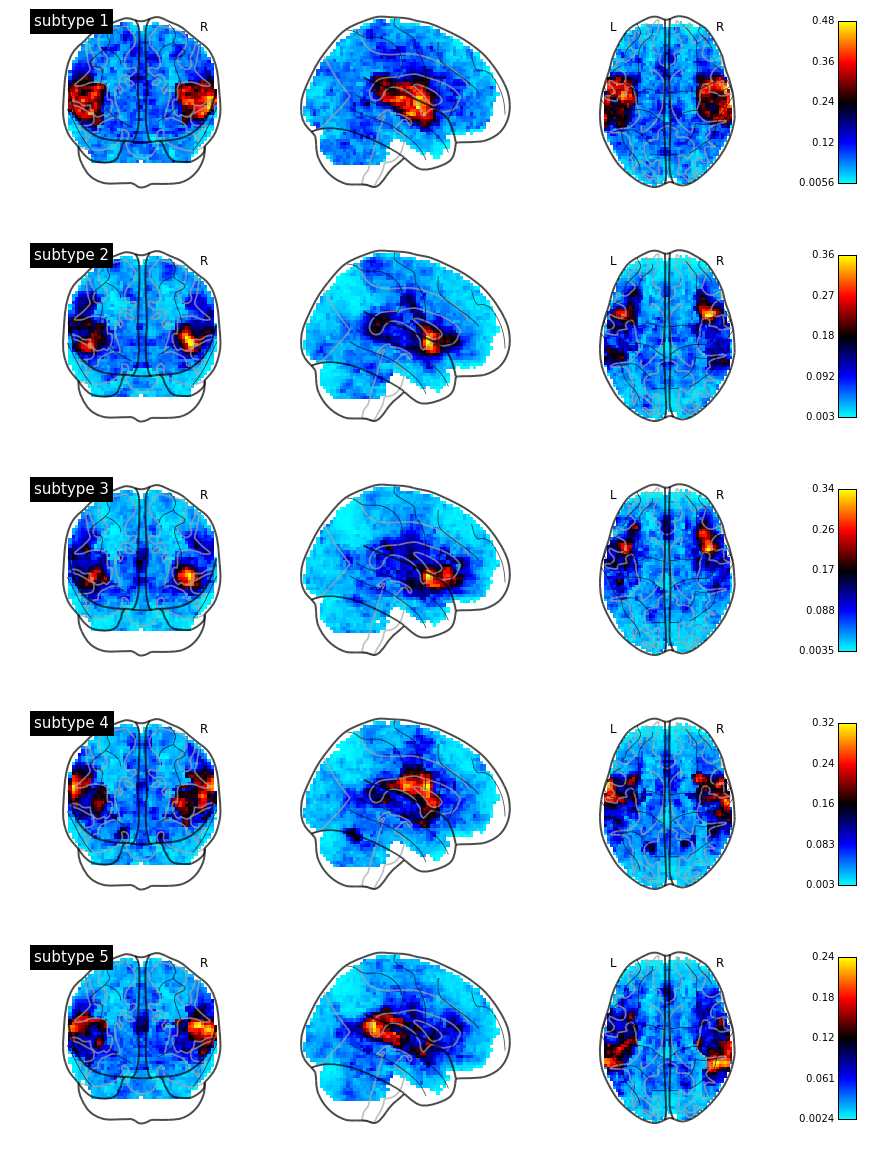

In [216]:
# Compare this to the rest of the subtypes for this network
net1_fig_demeaned = show_all_subtypes(sbt_store, 1, mask, m_img, fsz=(15,20))
net1_fig_demeaned.savefig(os.path.join(out_path, 'network_2_subtypes_demeaned.png'), dpi=100)

Subtype 3 looks like the opposite of subtype 5. However, even without FDR, there isn't a strong association with diagnosis. However, if we look at the (insignificant) association, there is a flip in the sign of the t-value.

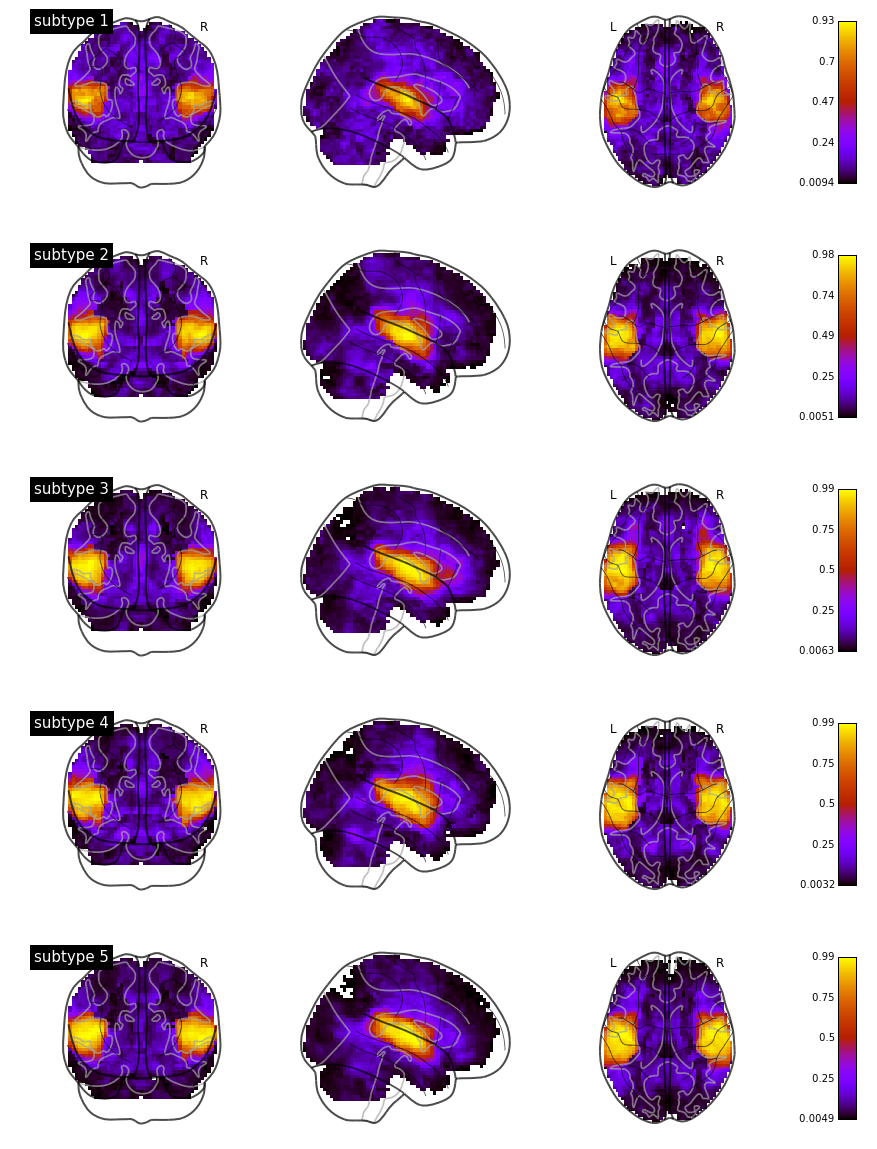

In [215]:
# Do the same with the non-demeaned subtypes
net1_fig = show_all_subtypes(sbt_store_2, 1, mask, m_img, fsz=(15,20), colm=plt.cm.gnuplot)
net1_fig.savefig(os.path.join(out_path, 'network_2_subtypes.png'), dpi=100)

In [155]:
# Look at subtype 5
print(res_store[1][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     5.987
Date:                Tue, 08 Sep 2015   Prob (F-statistic):           1.02e-08
Time:                        22:50:33   Log-Likelihood:                 131.08
No. Observations:                 189   AIC:                            -236.2
Df Residuals:                     176   BIC:                            -194.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2313      0.051      4.542      

In [156]:
# Look at subtype 3
print(res_store[1][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     7.369
Date:                Tue, 08 Sep 2015   Prob (F-statistic):           6.74e-11
Time:                        22:50:34   Log-Likelihood:                 115.47
No. Observations:                 189   AIC:                            -204.9
Df Residuals:                     176   BIC:                            -162.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1096      0.055      1.982      

In [223]:
type(res_store[1][2].summary())

statsmodels.iolib.summary.Summary

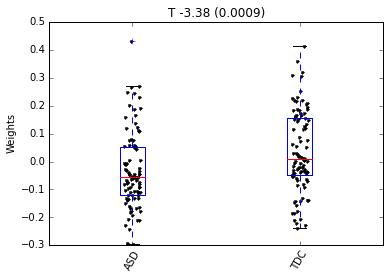

In [157]:
# Take a look at the weights for network 2 and subtype 5
sbt_weights = weight_store[1,4,:]
# Get the weights for the asd and tdc cases
asd_weights = sbt_weights[sub_asd]
tdc_weights = sbt_weights[sub_tdc]
# Show that stuff
cat_weights([asd_weights, tdc_weights])

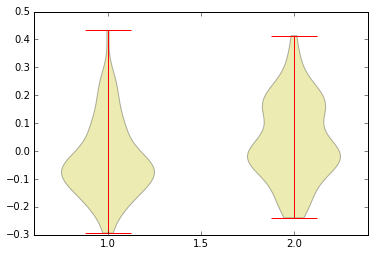

In [158]:
a = plt.violinplot([asd_weights, tdc_weights])

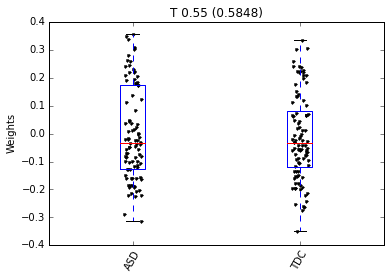

In [224]:
# Take a look at the weights for network 2 and subtype 3
sbt_weights = weight_store[1,2,:]
# Get the weights for the asd and tdc cases
asd_weights = sbt_weights[sub_asd]
tdc_weights = sbt_weights[sub_tdc]
# Show that stuff
cat_weights([asd_weights, tdc_weights])

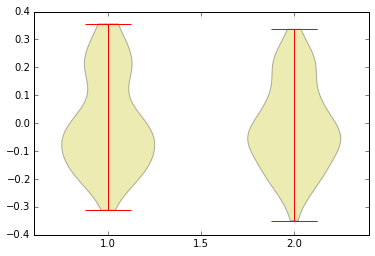

In [225]:
a = plt.violinplot([asd_weights, tdc_weights])

# Network 4

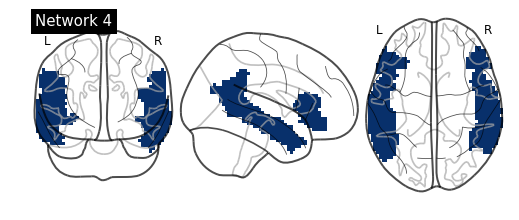

In [159]:
# Show network 4
n4 = np.zeros_like(prior)
n4[prior==4] = 1
n4_img = nib.Nifti1Image(n4, affine=p_img.get_affine(), header=p_img.get_header())
# Visualize the thing with nilearn
nlp.plot_glass_brain(n4_img, title='Network 4', cmap=plt.cm.Blues_r)

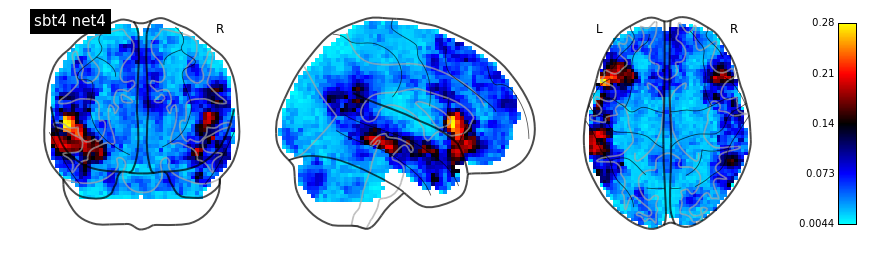

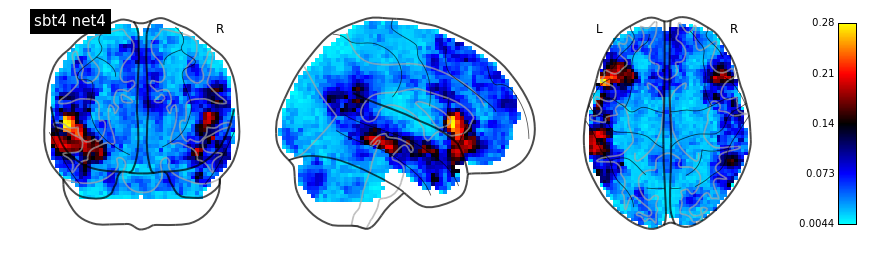

In [217]:
show_subtype(sbt_store[3,3,:], mask, m_img, fsz=(15,4), tit='sbt4 net4')

In [161]:
# Save subtype 5 to disk
save_path = os.path.join(out_path, 'network_4_subtype_4.nii.gz')
save_nifti(sbt_store[3,3,:], m_img, save_path)

'saved @ /data1/subtypes/sc12/network_4_subtype_4.nii.gz'

In [162]:
# Also save the other subtypes to disk
save_path = os.path.join(out_path, 'network_4_subtypes.nii.gz')
save_4D_nifti(sbt_store[3,...], m_img, save_path)

save_path = os.path.join(out_path, 'network_4_subtypes_not_demean.nii.gz')
save_4D_nifti(sbt_store_2[3,...], m_img, save_path)

'stored the volume @ /data1/subtypes/sc12/network_4_subtypes_not_demean.nii.gz'

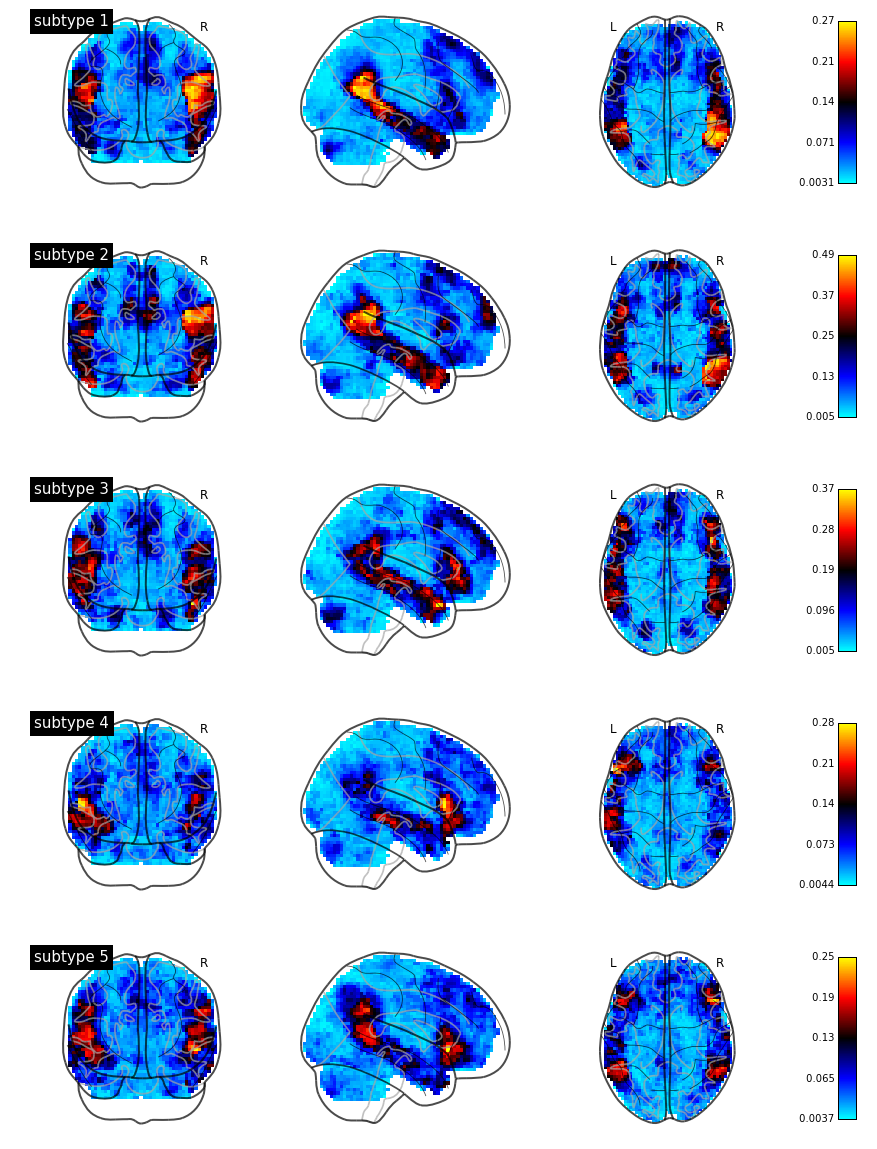

In [206]:
# Compare this to the rest of the subtypes for this network
net4_fig_demeaned = show_all_subtypes(sbt_store, 3, mask, m_img, fsz=(15,20))
net4_fig_demeaned.savefig(os.path.join(out_path, 'network_4_subtypes_demeaned.png'), dpi=100)

Subtype 4 appears to be the only one that is strongly left lateralized as opposed to the other subtypes which have their points of highest intensity on the right side. In a sense, subtype 5 is the opposite of subtype 4, since it shows a similar (but not identical) pattern, but on the right side. And while only subtype 4 passes FDR, subtype 5 shows a significant association with diagnosis before FDR. Interestingly, the sign of the t-values associated with both subtype contrasts is inverse. With a negative sign for subtype 5 and a positive for subtype 4. The __current coding for diagnosis is 1 for ASD and 2 for control__. So a positive sign means that being more associated with subtype 4 indicates that one is more control-like and vice verca.

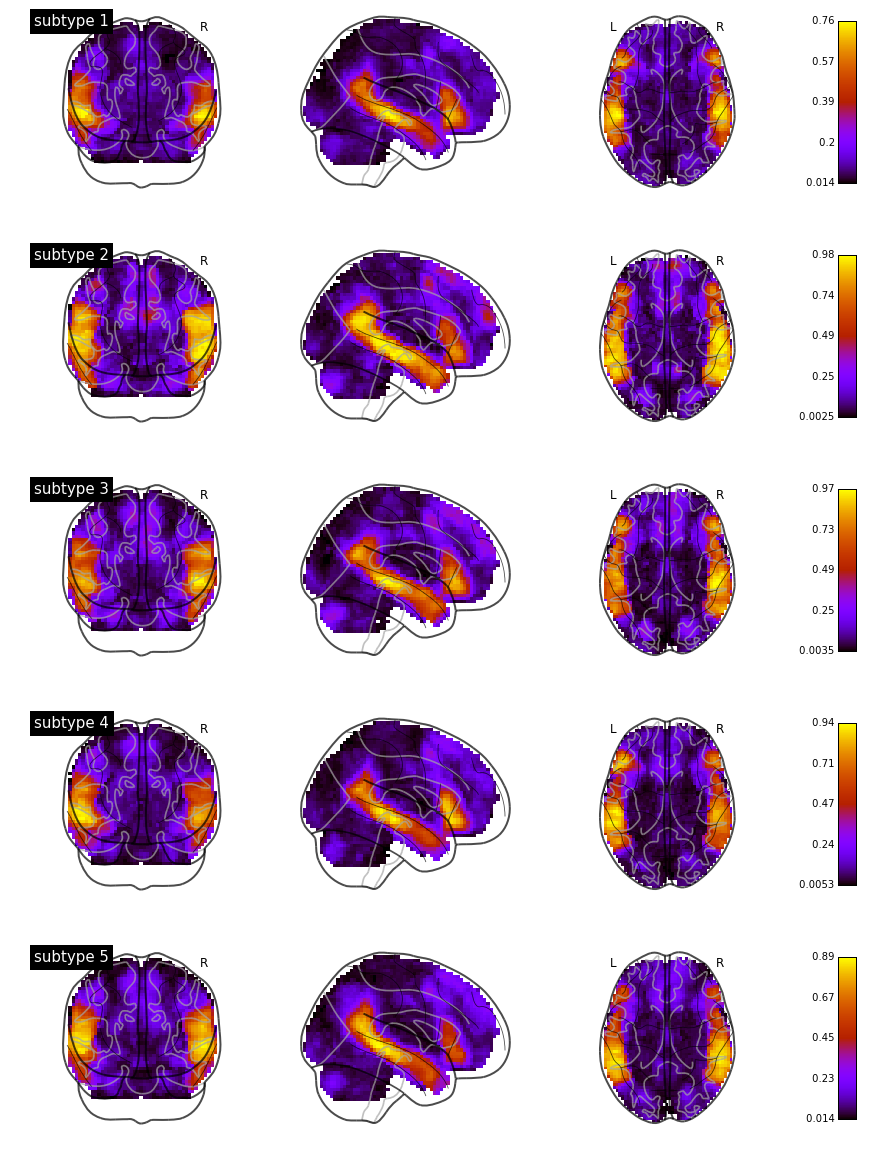

In [219]:
net4_fig = show_all_subtypes(sbt_store_2, 3, mask, m_img, fsz=(15,20), colm=plt.cm.gnuplot)
net4_fig.savefig(os.path.join(out_path, 'network_4_subtypes.png'), dpi=100)

In [165]:
asd_weights = weight_store[1,4,pheno['DX_GROUP'].values==1]
tdc_weights = weight_store[1,4,pheno['DX_GROUP'].values==2]

In [166]:
# Look at subtype 5
print(res_store[3][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.816
Date:                Tue, 08 Sep 2015   Prob (F-statistic):             0.0487
Time:                        22:50:57   Log-Likelihood:                 103.09
No. Observations:                 189   AIC:                            -180.2
Df Residuals:                     176   BIC:                            -138.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0362      0.059      0.614      

In [167]:
# Look at subtype 4
print(res_store[3][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     4.110
Date:                Tue, 08 Sep 2015   Prob (F-statistic):           1.17e-05
Time:                        22:50:57   Log-Likelihood:                 149.81
No. Observations:                 189   AIC:                            -273.6
Df Residuals:                     176   BIC:                            -231.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0862      0.046      1.870      

<matplotlib.colorbar.Colorbar instance at 0x3988ac68>

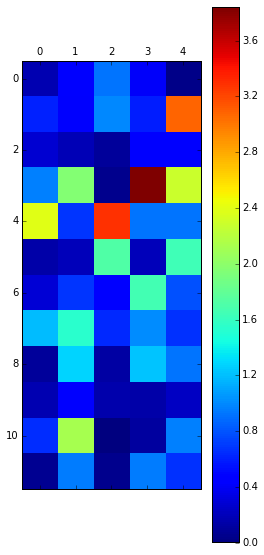

In [168]:
plt.matshow(-np.log10(pval_store))
plt.colorbar()

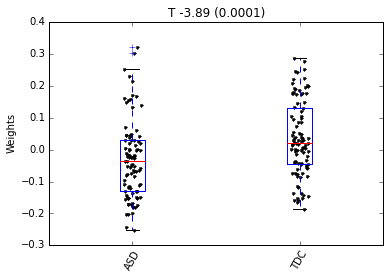

In [169]:
# Take a look at the weights for network 4 and subtype 4
sbt_weights = weight_store[3,3,:]
# Get the weights for the asd and tdc cases
asd_weights = sbt_weights[sub_asd]
tdc_weights = sbt_weights[sub_tdc]
# Show that stuff
cat_weights([asd_weights, tdc_weights])

# Network 5

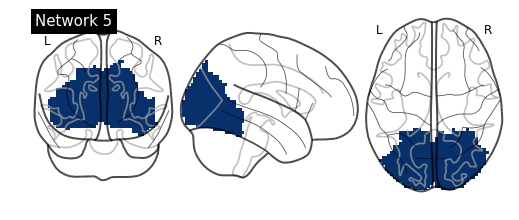

In [170]:
# Show network 5
n5 = np.zeros_like(prior)
n5[prior==5] = 1
n5_img = nib.Nifti1Image(n5, affine=p_img.get_affine(), header=p_img.get_header())
# Visualize the thing with nilearn
nlp.plot_glass_brain(n5_img, title='Network 5', cmap=plt.cm.Blues_r)

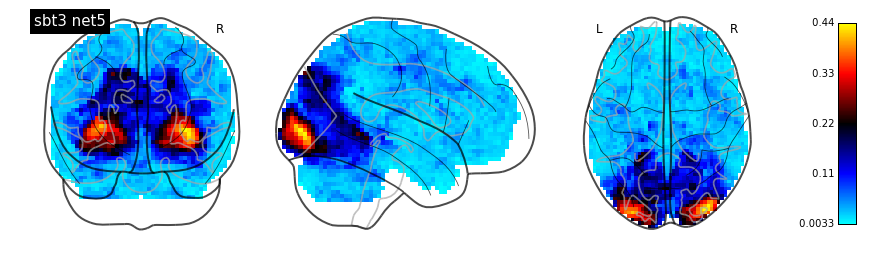

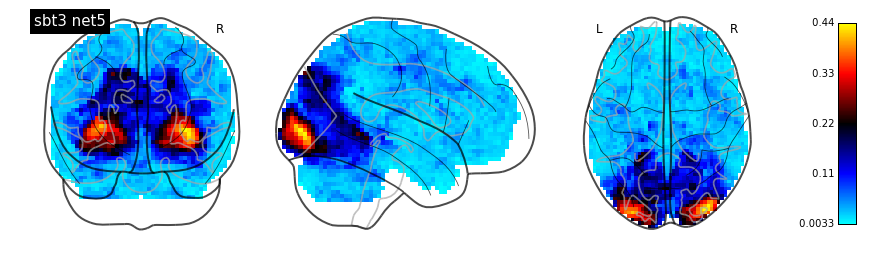

In [208]:
show_subtype(sbt_store[4,2,:], mask, m_img, fsz=(15,4), tit='sbt3 net5')

In [172]:
# Save subtype 5 to disk
save_path = os.path.join(out_path, 'network_5_subtype_3.nii.gz')
save_nifti(sbt_store[4,2,:], m_img, save_path)

'saved @ /data1/subtypes/sc12/network_5_subtype_3.nii.gz'

In [173]:
# Also save the other subtypes to disk
save_path = os.path.join(out_path, 'network_5_subtypes.nii.gz')
save_4D_nifti(sbt_store[4,...], m_img, save_path)

save_path = os.path.join(out_path, 'network_5_subtypes_not_demeaned.nii.gz')
save_4D_nifti(sbt_store_2[4,...], m_img, save_path)

'stored the volume @ /data1/subtypes/sc12/network_5_subtypes_not_demeaned.nii.gz'

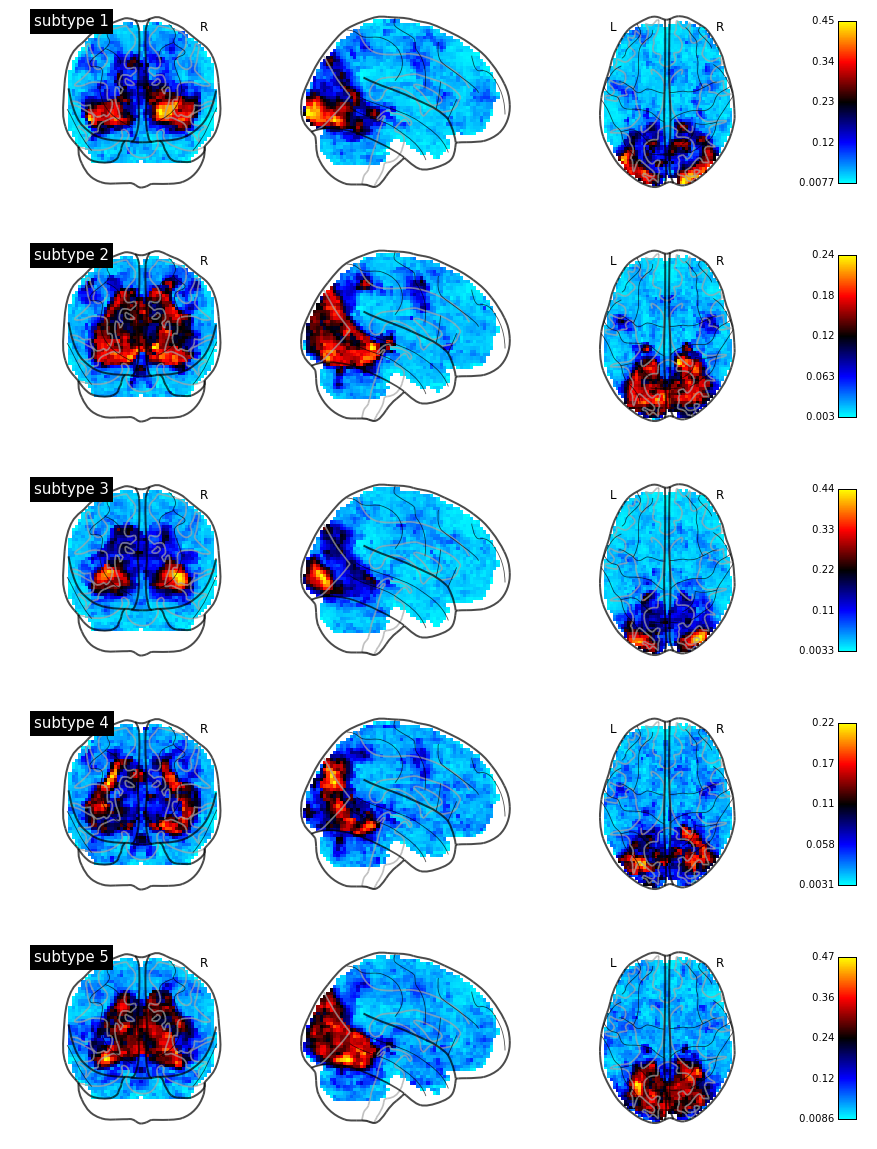

In [209]:
# Compare this to the rest of the subtypes for this networkb
net5_fig_demeaned = show_all_subtypes(sbt_store, 4, mask, m_img, fsz=(15,20))
net5_fig_demeaned.savefig(os.path.join(out_path, 'network_5_subtypes_demeaned.png'), dpi=100)

Subtype 3 appears to be the opposite of subtype 4, although subtype 4 doesn't show a significant association with diagnosis. Subtype 3 is also visually similar to subtype 1 which again doesn't show an association with diagnosis that survives FDR. However, unlike subtype 4, subtype 1 shows an uncorrected association with diagnosis (before FDR). So this is something like approaching significance, I guess. More interestingly, although subtype 1 looks very similar, it has an inverse sign (i.e. the opposite effect of subtype 3).

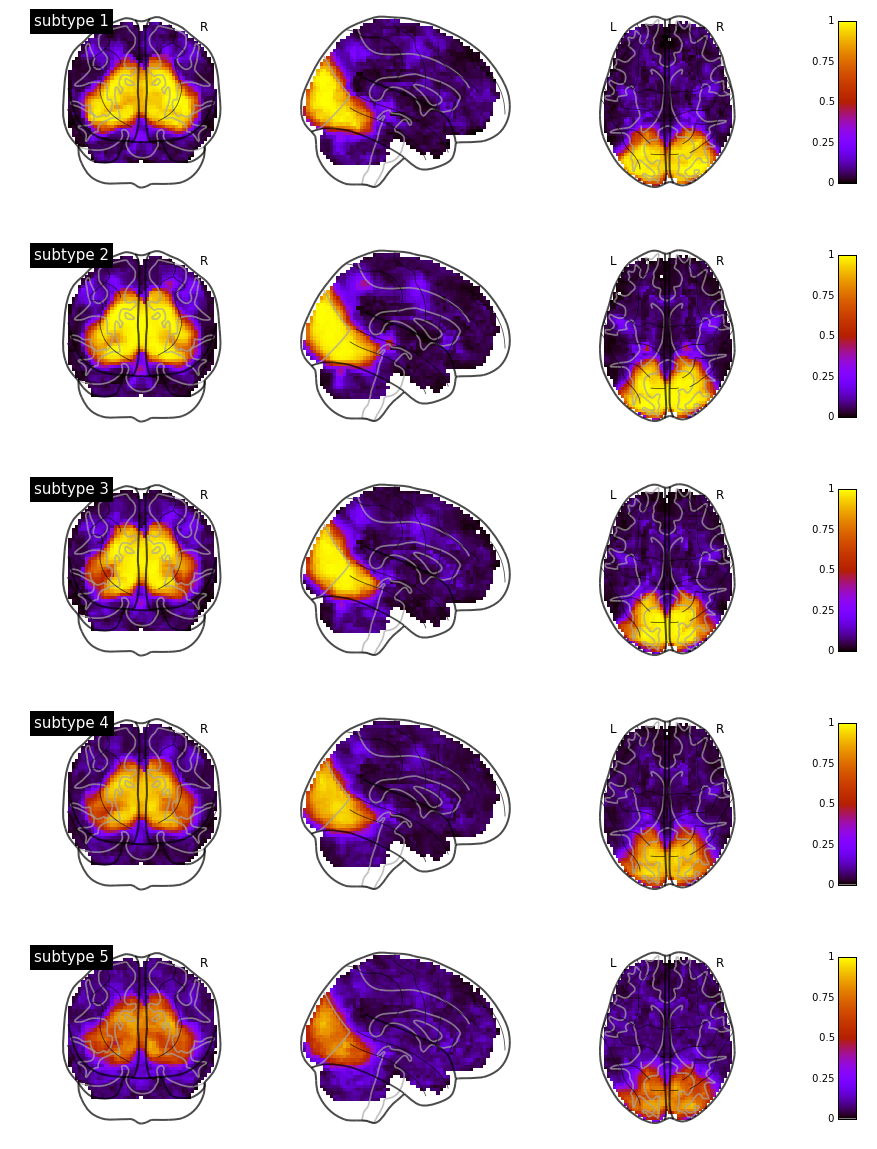

In [210]:
# Compare this to the rest of the subtypes for this network
net5_fig = show_all_subtypes(sbt_store_2, 4, mask, m_img, fsz=(15,20), rng=(0,1), colm=plt.cm.gnuplot)
net5_fig.savefig(os.path.join(out_path, 'network_5_subtypes.png'), dpi=100)

In [268]:
std_map = np.std(sbt_store[1,:],0)

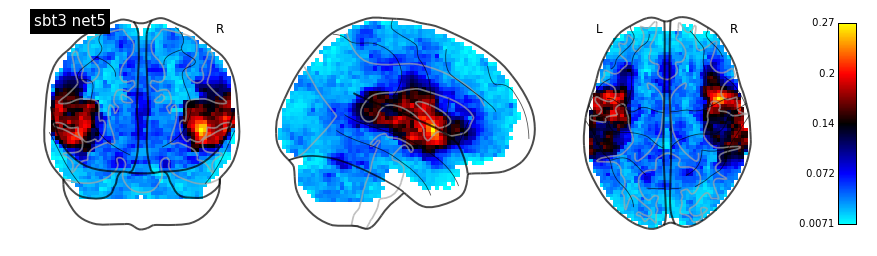

In [270]:
tmp = show_subtype(std_map, mask, m_img, fsz=(15,4), tit='sbt3 net5')

In [220]:
# Look at the results for subtype 3
print(res_store[4][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     4.727
Date:                Wed, 09 Sep 2015   Prob (F-statistic):           1.13e-06
Time:                        10:16:23   Log-Likelihood:                 71.849
No. Observations:                 189   AIC:                            -117.7
Df Residuals:                     176   BIC:                            -75.56
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1322      0.070     -1.898      

In [221]:
# Look at the results for subtype 1
print(res_store[4][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     5.581
Date:                Wed, 09 Sep 2015   Prob (F-statistic):           4.57e-08
Time:                        10:16:33   Log-Likelihood:                 76.010
No. Observations:                 189   AIC:                            -126.0
Df Residuals:                     176   BIC:                            -83.88
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2815      0.068      4.130      

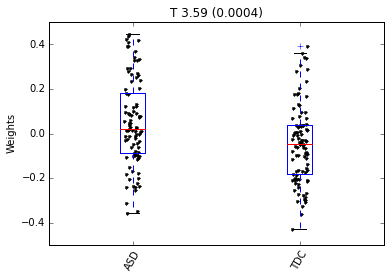

In [176]:
# Take a look at the weights for network 4 and subtype 3
sbt_weights = weight_store[4,2,:]
# Get the weights for the asd and tdc cases
asd_weights = sbt_weights[sub_asd]
tdc_weights = sbt_weights[sub_tdc]
# Show that stuff
cat_weights([asd_weights, tdc_weights])

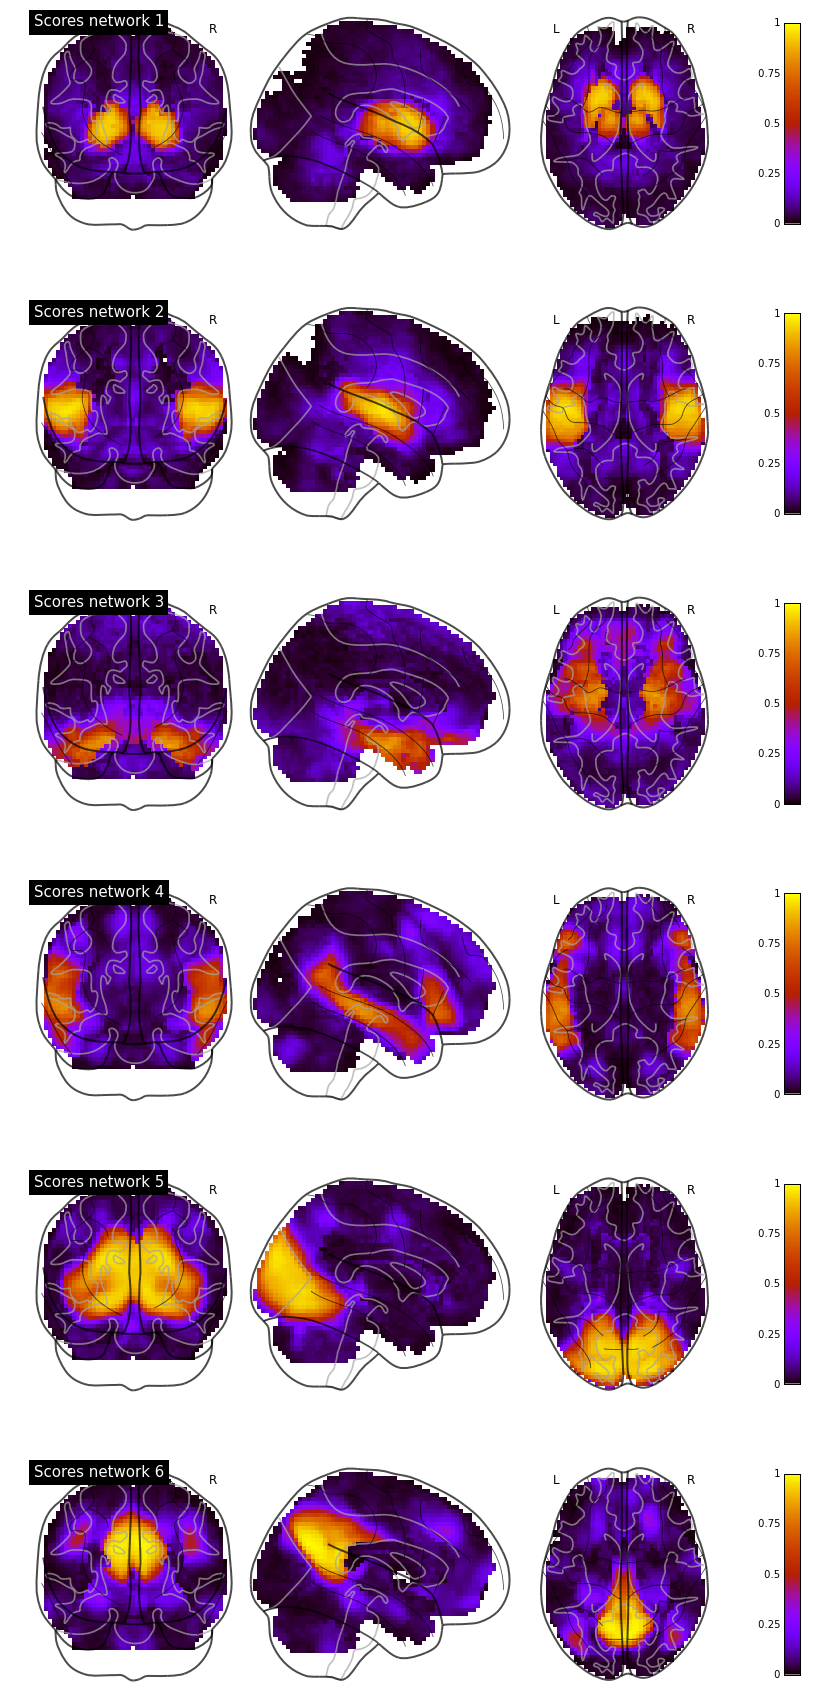

In [232]:
import nilearn as nil
fig = plt.figure(figsize=(14,30))
gs = gridspec.GridSpec(6, 1, hspace=0.3)
for s_id in np.arange(0,6):
    ax = fig.add_subplot(gs[s_id,0])
    nlp.plot_glass_brain(nil.image.index_img(gdvp,s_id), cmap=plt.cm.gnuplot, 
                         axes=ax, colorbar=True, title='Scores network {}'.format(s_id+1),
                        vmin=0, vmax=1)
fig.savefig(os.path.join(out_path, 'grand_average_1.png'), dpi=150)

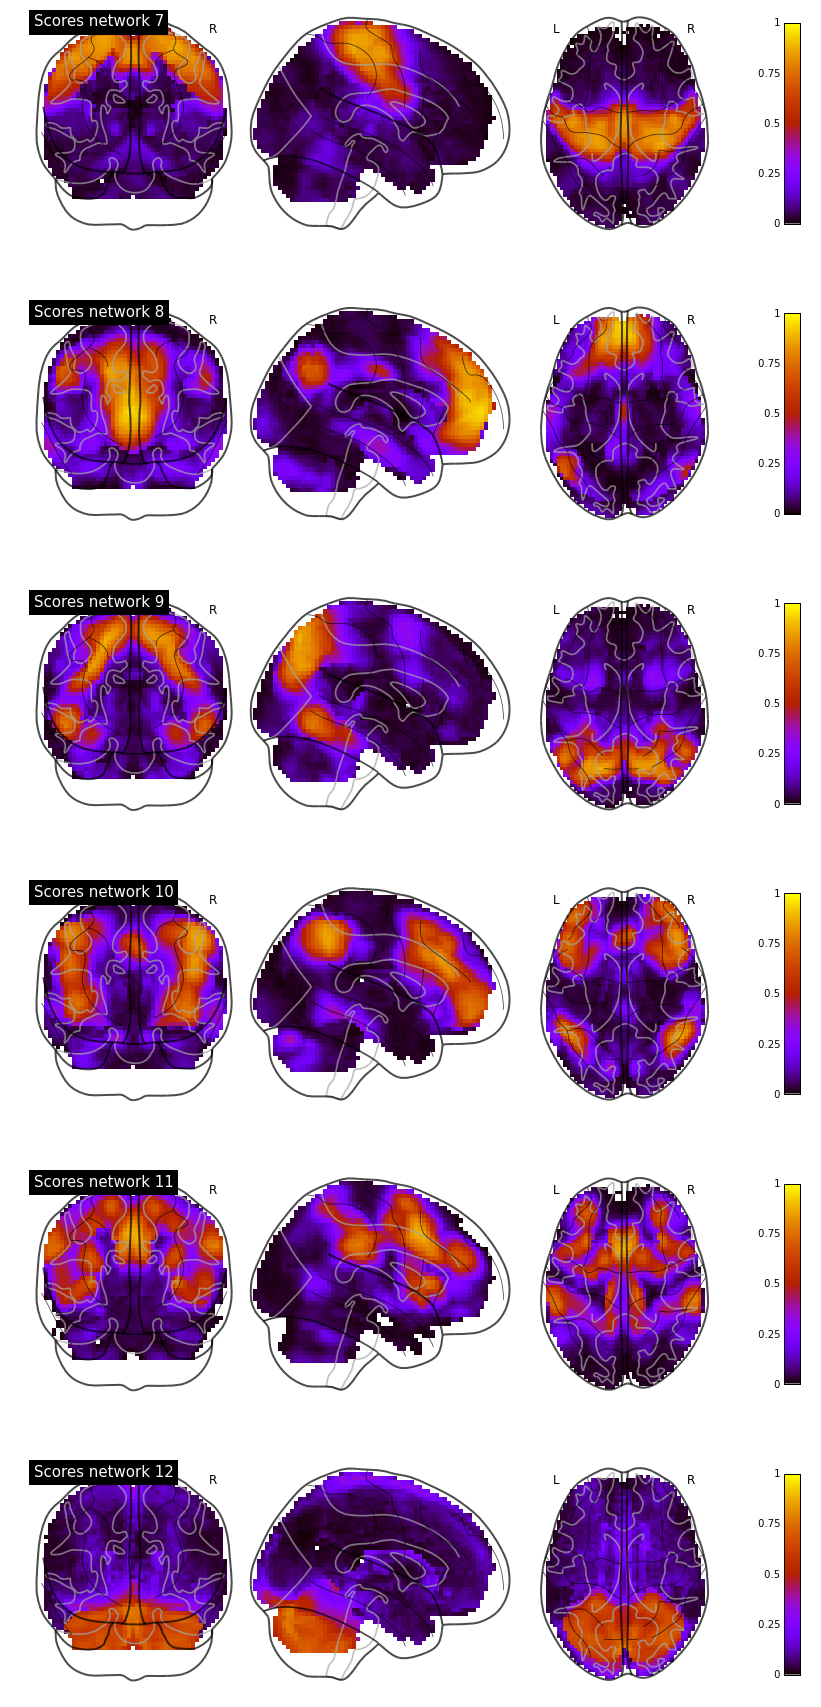

In [233]:
fig = plt.figure(figsize=(14,30))
gs = gridspec.GridSpec(6, 1, hspace=0.3)
for s_id in np.arange(6,12):
    ax = fig.add_subplot(gs[s_id-6,0])
    nlp.plot_glass_brain(nil.image.index_img(gdvp,s_id), cmap=plt.cm.gnuplot, 
                         axes=ax, colorbar=True, title='Scores network {}'.format(s_id+1),
                        vmin=0, vmax=1)
fig.savefig(os.path.join(out_path, 'grand_average_2.png'), dpi=150)

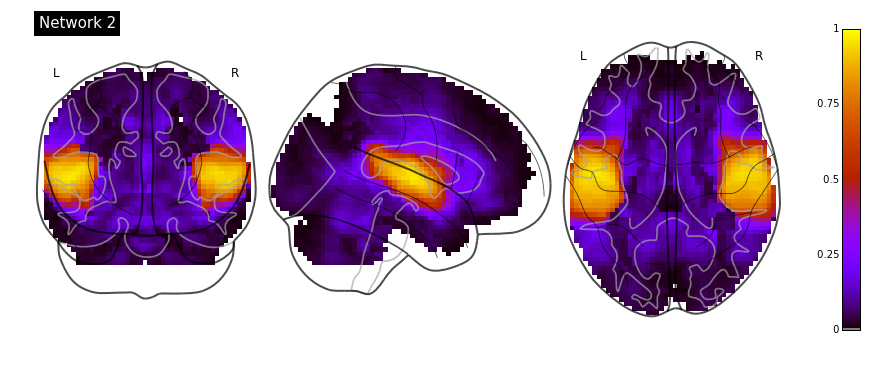

In [212]:
# Network 2
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
nlp.plot_glass_brain(nil.image.index_img(gdvp,1), cmap=plt.cm.gnuplot, 
                     axes=ax, colorbar=True, title='Network 2',
                     vmin=0, vmax=1)
fig.savefig(os.path.join(out_path, 'network_2_scores_avg.png'), dpi=100)

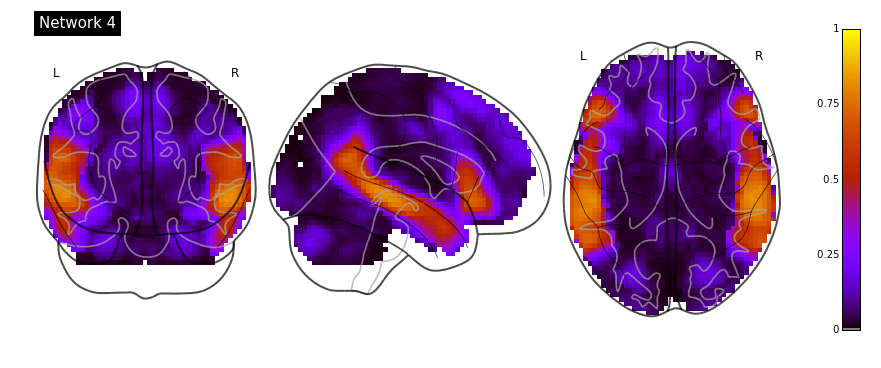

In [213]:
# Network 4
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
nlp.plot_glass_brain(nil.image.index_img(gdvp,3), cmap=plt.cm.gnuplot, 
                     axes=ax, colorbar=True, title='Network 4',
                     vmin=0, vmax=1)
fig.savefig(os.path.join(out_path, 'network_4_scores_avg.png'), dpi=100)

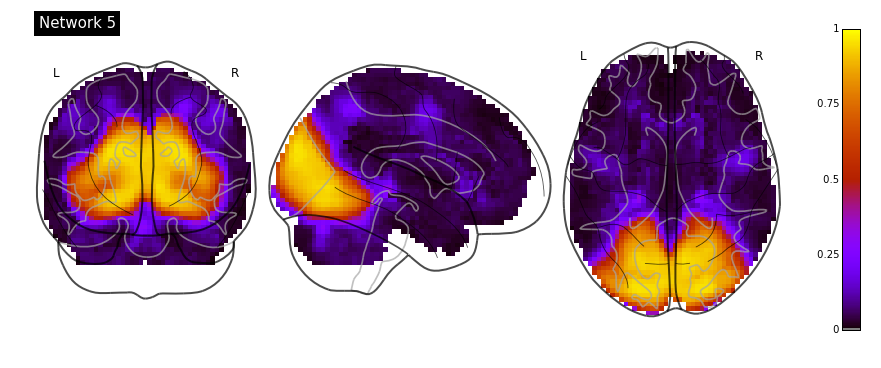

In [214]:
# Network 5
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
nlp.plot_glass_brain(nil.image.index_img(gdvp,4), cmap=plt.cm.gnuplot, 
                     axes=ax, colorbar=True, title='Network 5',
                     vmin=0, vmax=1)
fig.savefig(os.path.join(out_path, 'network_5_scores_avg.png'), dpi=100)

In [242]:
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=p_img.get_affine(), header=p_img.get_header())

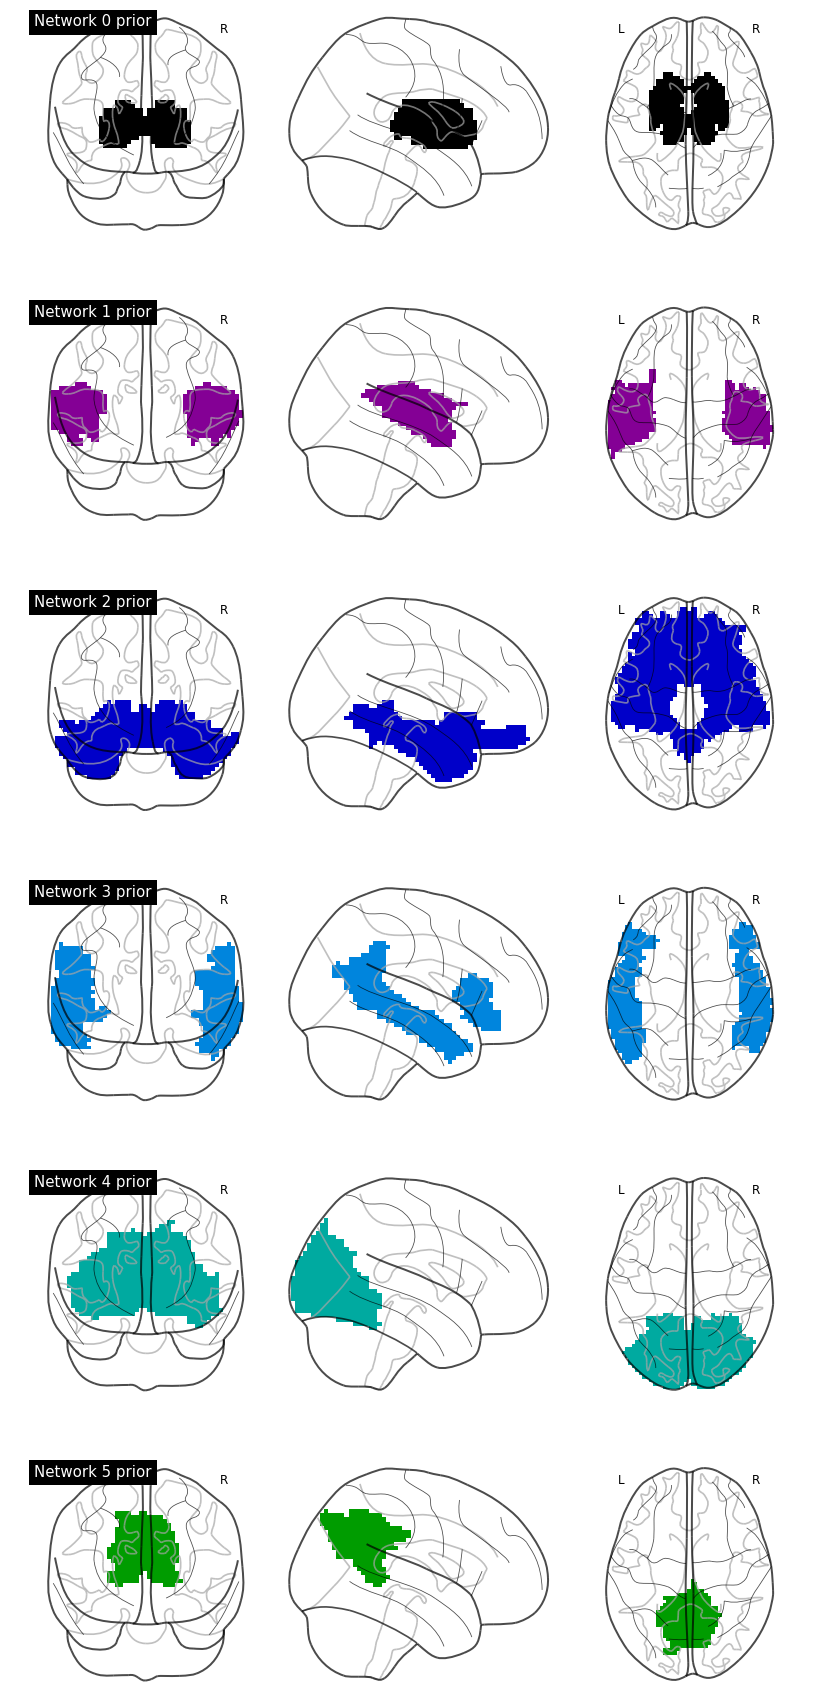

In [251]:
# Show the network priors
fig = plt.figure(figsize=(14,30))
gs = gridspec.GridSpec(6, 1, hspace=0.3)
for s_id in np.arange(0,6):
    ax = fig.add_subplot(gs[s_id,0])
    nlp.plot_glass_brain(nil.image.index_img(prior_img,s_id), cmap=plt.cm.spectral, 
                         axes=ax, colorbar=False, title='Network {} prior'.format(s_id),
                        vmin=1, vmax=12)
fig.savefig(os.path.join(out_path, 'network_priors_1.png'), dpi=150)

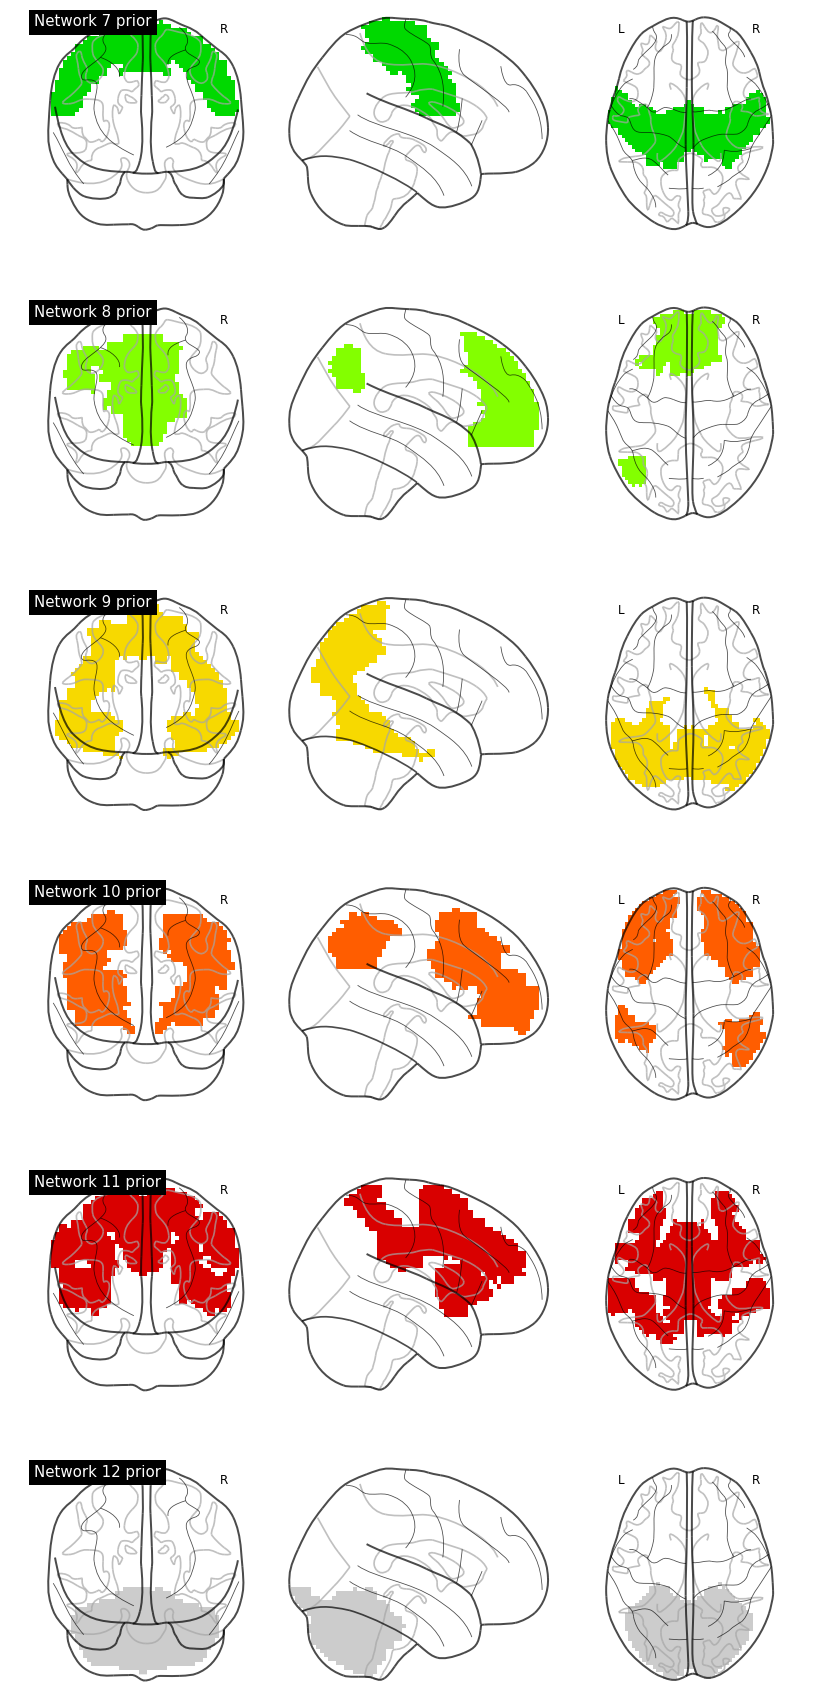

In [250]:
# Show the network priors
fig = plt.figure(figsize=(14,30))
gs = gridspec.GridSpec(6, 1, hspace=0.3)
for s_id in np.arange(6,12):
    ax = fig.add_subplot(gs[s_id-6,0])
    nlp.plot_glass_brain(nil.image.index_img(prior_img,s_id), cmap=plt.cm.spectral, 
                         axes=ax, colorbar=False, title='Network {} prior'.format(s_id+1),
                        vmin=1, vmax=12)
fig.savefig(os.path.join(out_path, 'network_priors_2.png'), dpi=150)

In [276]:
np.max(sbt_store_2[2,:])

0.96103448275862069

(array([  5.00000000e+00,   1.06000000e+02,   5.09000000e+02,
          3.43400000e+03,   3.56710000e+04,   3.77400000e+03,
          1.23900000e+03,   4.50000000e+02,   1.10000000e+02,
          1.10000000e+01]),
 array([-0.31577814, -0.24323645, -0.17069476, -0.09815307, -0.02561138,
         0.0469303 ,  0.11947199,  0.19201368,  0.26455537,  0.33709706,
         0.40963875]),
 <a list of 10 Patch objects>)

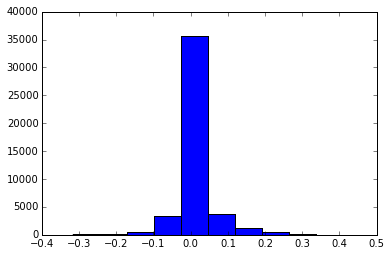

In [278]:
plt.hist(sbt_store[2,3])

In [277]:
gdavg.shape

(53, 64, 52, 12)